In [1]:
!pip install transformers==4.29.1 librosa datasets jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 4.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 67.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.8/316.8 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 34.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 89.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/2

In [2]:
import os
import time
from multiprocessing import get_context

from tqdm import tqdm
from datasets import load_dataset, Audio
import pandas as pd

from transformers import Wav2Vec2ForCTC, AutoProcessor
from transformers import HubertForCTC
from transformers import WhisperProcessor, WhisperForConditionalGeneration


import torch

# Get model Predictions

In [3]:
# dataset = load_dataset("audiofolder", data_dir="../accentsDB")
dataset = load_dataset("prince-canuma/accentsDB-with-transcripts")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/12585 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /home/.cache/huggingface/datasets/prince-canuma___parquet/prince-canuma--accentsDB-with-transcripts-dabed51a66149d1f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 12585
    })
})

In [ ]:
dataset['train'][2]['audio']

{'path': '/Users/prince_canuma/Documents/Projects/MSc thesis/accentsDB/data/american/speaker_01/american_s01_003.wav',
 'array': array([0., 0., 0., ..., 0., 0., 0.]),
 'sampling_rate': 22050}

In [4]:
def map_to_array(batch):
    batch["speech"] = batch["audio"]["array"]
    return batch

def remove_punctuation(input_string):
    # Remove punctuation characters from the input string
    no_punct_string = input_string.replace(".", "")
    return no_punct_string

def map_to_pred(batch, pool, model_name, model, processor):
    if "whisper" in model_name:
        inputs = processor(batch["speech"], sampling_rate=16000, return_tensors="pt")
    else:
        inputs = processor(batch["speech"], sampling_rate=16000, return_tensors="pt", padding=True)

    inputs = {k: inputs[k].to("cuda") for k in inputs}

    with torch.no_grad():
        if "whisper" in model_name:
            predicted_ids = model.generate(**inputs)[0]
        else:
            logits = model(**inputs).logits
    if "whisper" in model_name:
        transcription = processor.decode(predicted_ids.cpu().numpy(), skip_special_tokens=True, pool=pool)
    else:
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.batch_decode(predicted_ids, pool)

    batch[f"transcription_{model_name}"] = transcription
    return batch

In [5]:
dataset = dataset.map(map_to_array, remove_columns=["audio"])

Map:   0%|          | 0/12585 [00:00<?, ? examples/s]

In [6]:
def get_transcriptions(model_name, model, processor, batched, batch_size):

    with get_context("fork").Pool(processes=2) as pool:

        return dataset.map(
            map_to_pred,
            batched=batched,
            batch_size=batch_size,
            remove_columns=["speech"],
            fn_kwargs={"processor": processor, "model_name": model_name, "model": model, "pool": pool},
        )

def save_predictions(model_name, model, processor, batched=True, batch_size=2):

    result = get_transcriptions(model_name, model, processor, batched, batch_size)
    result["train"].to_pandas().to_csv(f"../results/{model_name}_results.csv",index=False)

In [7]:
wav2vec2_processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec2 = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to("cuda")

save_predictions("wav2vec2", wav2vec2, wav2vec2_processor, batch_size=8)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Parameter 'fn_kwargs'={'processor': Wav2Vec2Processor:
- feature_extractor: Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

- tokenizer: Wav2Vec2CTCTokenizer(name_or_path='facebook/wav2vec2-base-960h', vocab_size=32, model_max_length=9223372036854775807, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True), 'model_name': 'wav2vec2', 'model': Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2M

Map:   0%|          | 0/12585 [00:00<?, ? examples/s]

In [8]:
hubert_processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
hubert = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft").to("cuda")
save_predictions("hubert", hubert, hubert_processor)

Map:   0%|          | 0/12585 [00:00<?, ? examples/s]

In [9]:
whisper_base_processor = WhisperProcessor.from_pretrained("openai/whisper-base")
whisper_base = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base").to("cuda")

save_predictions("whisper_base", whisper_base, whisper_base_processor, batched=False, batch_size=1)

Map:   0%|          | 0/12585 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [10]:
whisper_base_en_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
whisper_base_en = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base.en").to("cuda")

save_predictions("whisper_base_en", whisper_base_en, whisper_base_en_processor, batched=False, batch_size=1)

Map:   0%|          | 0/12585 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


# Evaluation

The primary metric for evaluation will be the Word Error Rate(WER), which measures the percentage of words that were transcribed incorrectly. Additionally, we will use the Character Error(CER) to measure the number of character-level mistakes in the transcriptions. These metrics will provide a clear picture of the transcription accuracy of the evaluated models.

In [29]:
import pandas as pd
from jiwer import cer, wer

In [2]:
wav2vec2_df = pd.read_csv("../results/wav2vec2_results.csv")
hubert_df = pd.read_csv("../results/hubert_results.csv")
whisper_base_df = pd.read_csv("../results/whisper_base_results.csv")
whisper_base_en_df = pd.read_csv("../results/whisper_base_en_results.csv")
clean_df = pd.read_csv("../accentsDB/metadata.csv")

In [3]:
# Make whisper_base and whisper_base_en columns uppercase and remove commas and periods.
whisper_base_df['transcription_whisper_base'] = whisper_base_df['transcription_whisper_base'].str.upper().str.replace(',', '').str.replace('.', '')
whisper_base_en_df['transcription_whisper_base_en'] = whisper_base_en_df['transcription_whisper_base_en'].str.upper().str.replace(',', '').str.replace('.', '')

In [4]:
whisper_base_df.head()

,transcription,transcription_whisper_base
0,THE BIRCH CANOE SLID ON THE SMOOTH PLANKS,THE BIRCH CAN BE SLID ON THE SMOOTH PLANKS
1,GLUE THE SHEET TO THE DARK BLUE BACKGROUND,GLUE THE SHEET TO THE DARK BLUE BACKGROUND
2,IT'S EASY TO TELL THE DEPTH OF A WELL,IT'S EASY TO TELL THE DEPTH OF A WELL
3,THESE DAYS A CHICKEN LEG IS A RARE DISH,THESE DAYS THE CHICKEN LAG IS A RARE DISH
4,RICE IS OFTEN SERVED IN ROUND BOWLS,RICE IS OFTEN SERVED IN ROUND BOWLS


In [5]:
# Drop the transcription column from all dataframes.
wav2vec2_df = wav2vec2_df.drop(columns=['transcription'])
hubert_df = hubert_df.drop(columns=['transcription'])
whisper_base_df = whisper_base_df.drop(columns=['transcription'])
whisper_base_en_df = whisper_base_en_df.drop(columns=['transcription'])


In [6]:
# Merge all the dataframes into one dataframe.
merged_df = pd.concat([clean_df, wav2vec2_df, hubert_df, whisper_base_df, whisper_base_en_df], axis=1)
merged_df.head()

,transcription,file_name,transcription_wav2vec2,transcription_hubert,transcription_whisper_base,transcription_whisper_base_en
0,THE BIRCH CANOE SLID ON THE SMOOTH PLANKS,data/indian/speaker_02/indian_s02_001.wav,THOUGH BIRCH CANOE SLID ON THE SMOTH PLANKS,THOUG BIRCH CANOE SLID ON THE SMOTH PLANKS,THE BIRCH CAN BE SLID ON THE SMOOTH PLANKS,THE BIRCH CAN NOW SLID ON THE SMOOTH PLANKS
1,GLUE THE SHEET TO THE DARK BLUE BACKGROUND,data/indian/speaker_02/indian_s02_002.wav,GLUE THE SHET TO THE DARK BLUE BACKGROUND,GLUE THE SHET TO THE DARK BLUE BACKGROUND,GLUE THE SHEET TO THE DARK BLUE BACKGROUND,GLUE THE SHEET TO THE DARK BLUE BACKGROUND
2,IT'S EASY TO TELL THE DEPTH OF A WELL,data/indian/speaker_02/indian_s02_003.wav,IT'S EASY TO TEL THE DEPTH OF A WEL,IT'S EASY TO TEL THE DEPTH OF A WEL,IT'S EASY TO TELL THE DEPTH OF A WELL,IT'S EASY TO TELL THE DEPTH OF A WELL
3,THESE DAYS A CHICKEN LEG IS A RARE DISH,data/indian/speaker_02/indian_s02_004.wav,THESE DAYS A CHICKEN LEG IS A RARE DISH,THESE DAYS A CHICKEN LEG IS A RARE DISH,THESE DAYS THE CHICKEN LAG IS A RARE DISH,THESE DAYS A CHICKEN LEG IS A RARE DISH
4,RICE IS OFTEN SERVED IN ROUND BOWLS,data/indian/speaker_02/indian_s02_005.wav,RICE IS OFTEN SERVED IN ROUND BOWLS,RICE IS OFTEN SERVED IN ROUND BOWLS,RICE IS OFTEN SERVED IN ROUND BOWLS,RICE IS OFTEN SERVED IN ROUND BOWLS


In [7]:
# Make file_name the last column.
cols = list(merged_df.columns.values)
cols.pop(cols.index('file_name'))
merged_df = merged_df[cols+['file_name']]
merged_df.head()

,transcription,transcription_wav2vec2,transcription_hubert,transcription_whisper_base,transcription_whisper_base_en,file_name
0,THE BIRCH CANOE SLID ON THE SMOOTH PLANKS,THOUGH BIRCH CANOE SLID ON THE SMOTH PLANKS,THOUG BIRCH CANOE SLID ON THE SMOTH PLANKS,THE BIRCH CAN BE SLID ON THE SMOOTH PLANKS,THE BIRCH CAN NOW SLID ON THE SMOOTH PLANKS,data/indian/speaker_02/indian_s02_001.wav
1,GLUE THE SHEET TO THE DARK BLUE BACKGROUND,GLUE THE SHET TO THE DARK BLUE BACKGROUND,GLUE THE SHET TO THE DARK BLUE BACKGROUND,GLUE THE SHEET TO THE DARK BLUE BACKGROUND,GLUE THE SHEET TO THE DARK BLUE BACKGROUND,data/indian/speaker_02/indian_s02_002.wav
2,IT'S EASY TO TELL THE DEPTH OF A WELL,IT'S EASY TO TEL THE DEPTH OF A WEL,IT'S EASY TO TEL THE DEPTH OF A WEL,IT'S EASY TO TELL THE DEPTH OF A WELL,IT'S EASY TO TELL THE DEPTH OF A WELL,data/indian/speaker_02/indian_s02_003.wav
3,THESE DAYS A CHICKEN LEG IS A RARE DISH,THESE DAYS A CHICKEN LEG IS A RARE DISH,THESE DAYS A CHICKEN LEG IS A RARE DISH,THESE DAYS THE CHICKEN LAG IS A RARE DISH,THESE DAYS A CHICKEN LEG IS A RARE DISH,data/indian/speaker_02/indian_s02_004.wav
4,RICE IS OFTEN SERVED IN ROUND BOWLS,RICE IS OFTEN SERVED IN ROUND BOWLS,RICE IS OFTEN SERVED IN ROUND BOWLS,RICE IS OFTEN SERVED IN ROUND BOWLS,RICE IS OFTEN SERVED IN ROUND BOWLS,data/indian/speaker_02/indian_s02_005.wav


In [69]:
# Calculate the WER for each model and create a new dataframe with the results.
wer_df = pd.DataFrame(columns=['model', 'wer'])
wer_df['model'] = ['wav2vec2', 'hubert', 'whisper_base', 'whisper_base_en']
wer_df['wer'] = [wer(merged_df['transcription'].astype(str).tolist(), merged_df['transcription_wav2vec2'].astype(str).tolist()),
                    wer(merged_df['transcription'].astype(str).tolist(), merged_df['transcription_hubert'].astype(str).tolist()),
                    wer(merged_df['transcription'].astype(str).tolist(), merged_df['transcription_whisper_base'].astype(str).tolist()),
                    wer(merged_df['transcription'].astype(str).tolist(), merged_df['transcription_whisper_base_en'].astype(str).tolist())]
# add cer
wer_df['cer'] = [cer(merged_df['transcription'].astype(str).tolist(), merged_df['transcription_wav2vec2'].astype(str).tolist()),
                    cer(merged_df['transcription'].astype(str).tolist(), merged_df['transcription_hubert'].astype(str).tolist()),
                    cer(merged_df['transcription'].astype(str).tolist(), merged_df['transcription_whisper_base'].astype(str).tolist()),
                    cer(merged_df['transcription'].astype(str).tolist(), merged_df['transcription_whisper_base_en'].astype(str).tolist())]

wer_df.head()


,model,wer,cer
0,wav2vec2,0.665041,0.464469
1,hubert,0.628200,0.446882
2,whisper_base,0.938768,0.804884
3,whisper_base_en,0.891479,0.755049


In [31]:
wer_df.to_csv("../results/wer.csv",index=False)

In [74]:
models = ['wav2vec2', 'hubert', 'whisper_base', 'whisper_base_en']

# Add accent column to merged_df 
# example: data/india/speaker-> india
merged_df['accent'] = merged_df['file_name'].str.split('/').str[1].str.split('_').str[0]

dataframes = []

for model in models:
    for accent in merged_df['accent'].unique():
        accent_df = merged_df[merged_df['accent'] == accent]
        model_wer = wer(accent_df['transcription'].astype(str).tolist(), 
                        accent_df[f'transcription_{model}'].astype(str).tolist())
        model_cer = cer(accent_df['transcription'].astype(str).tolist(),
                        accent_df[f'transcription_{model}'].astype(str).tolist())
    
        mini_df = pd.DataFrame({'model': [model], 
                                'accent': [accent], 
                                'wer': [model_wer],
                                'cer': [model_cer]})
        dataframes.append(mini_df)

wer_accent_df = pd.concat(dataframes, ignore_index=True)

wer_accent_df.head()


,model,accent,wer,cer
0,wav2vec2,indian,0.177290,0.050668
1,wav2vec2,australian,0.278997,0.098341
2,wav2vec2,odiya,1.018639,0.785332
3,wav2vec2,welsh,0.164228,0.044026
4,wav2vec2,bangla,1.014374,0.785358


In [33]:
wer_accent_df.to_csv("../results/wer_accent.csv",index=False)

In [34]:
wer_accent_df

,model,accent,wer,cer
0,wav2vec2,indian,0.177290,0.050668
1,wav2vec2,australian,0.278997,0.098341
2,wav2vec2,odiya,1.018639,0.785332
3,wav2vec2,welsh,0.164228,0.044026
4,wav2vec2,bangla,1.014374,0.785358
5,wav2vec2,british,0.231586,0.076578
6,wav2vec2,american,0.965017,0.727266
7,hubert,indian,0.142111,0.036676
8,hubert,australian,0.185998,0.058399
9,hubert,odiya,1.017784,0.784655


In [40]:
# Calculate the average WER for each model and create a new dataframe with the results.
wer_avg_df = pd.DataFrame(columns=['model', 'wer'])
wer_avg_df['model'] = ['wav2vec2', 'hubert', 'whisper_base', 'whisper_base_en']
wer_avg_df['wer'] = [wer_accent_df[wer_accent_df['model'] == 'wav2vec2']['wer'].mean(),
                    wer_accent_df[wer_accent_df['model'] == 'hubert']['wer'].mean(),
                    wer_accent_df[wer_accent_df['model'] == 'whisper_base']['wer'].mean(),
                    wer_accent_df[wer_accent_df['model'] == 'whisper_base_en']['wer'].mean()]

# add cer
wer_avg_df['cer'] = [wer_accent_df[wer_accent_df['model'] == 'wav2vec2']['cer'].mean(),
                    wer_accent_df[wer_accent_df['model'] == 'hubert']['cer'].mean(),
                    wer_accent_df[wer_accent_df['model'] == 'whisper_base']['cer'].mean(),
                    wer_accent_df[wer_accent_df['model'] == 'whisper_base_en']['cer'].mean()]
# add std
wer_avg_df['wer_std'] = [wer_accent_df[wer_accent_df['model'] == 'wav2vec2']['wer'].std(),
                    wer_accent_df[wer_accent_df['model'] == 'hubert']['wer'].std(),
                    wer_accent_df[wer_accent_df['model'] == 'whisper_base']['wer'].std(),
                    wer_accent_df[wer_accent_df['model'] == 'whisper_base_en']['wer'].std()]

wer_avg_df['cer_std'] = [wer_accent_df[wer_accent_df['model'] == 'wav2vec2']['cer'].std(),
                    wer_accent_df[wer_accent_df['model'] == 'hubert']['cer'].std(),
                    wer_accent_df[wer_accent_df['model'] == 'whisper_base']['cer'].std(),
                    wer_accent_df[wer_accent_df['model'] == 'whisper_base_en']['cer'].std()]


wer_avg_df.head()

,model,wer,cer,wer_std,cer_std
0,wav2vec2,0.550019,0.366796,0.422308,0.374325
1,hubert,0.512708,0.350387,0.449984,0.385267
2,whisper_base,0.589853,0.466263,0.625907,0.561685
3,whisper_base_en,0.562780,0.445027,0.620739,0.541630


In [36]:
wer_avg_df.to_csv("../results/wer_avg.csv",index=False)

In [45]:
from matplotlib import pyplot as plt
import seaborn as sns

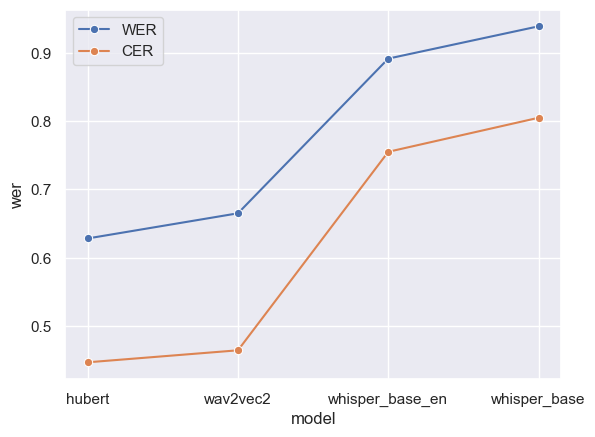

In [70]:
# plot a line plot of the WER for each model with the standard deviation
# order the models by WER

wer_df = wer_df.sort_values(by=['wer'])
sns.set_theme(style="darkgrid")
sns.lineplot(data=wer_df, x="model", y="wer", marker='o', label='WER')
sns.lineplot(data=wer_df, x="model", y="cer", marker='o', label='CER')
plt.legend()   
plt.savefig('../results/wer_avg.png')


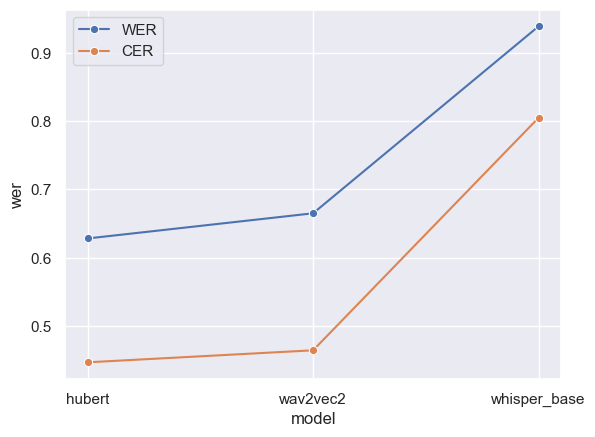

In [71]:
# plot a line plot of the WER for each model with the standard deviation
# exclude whisper_base_en
wer_df = wer_df[wer_df['model'] != 'whisper_base_en']
# order the models by WER
wer_df = wer_df.sort_values(by=['wer'])
sns.set_theme(style="darkgrid")
sns.lineplot(data=wer_df, x="model", y="wer", marker='o', label='WER')
sns.lineplot(data=wer_df, x="model", y="cer", marker='o', label='CER')
plt.legend()   
plt.savefig('../results/wer_avg.png')



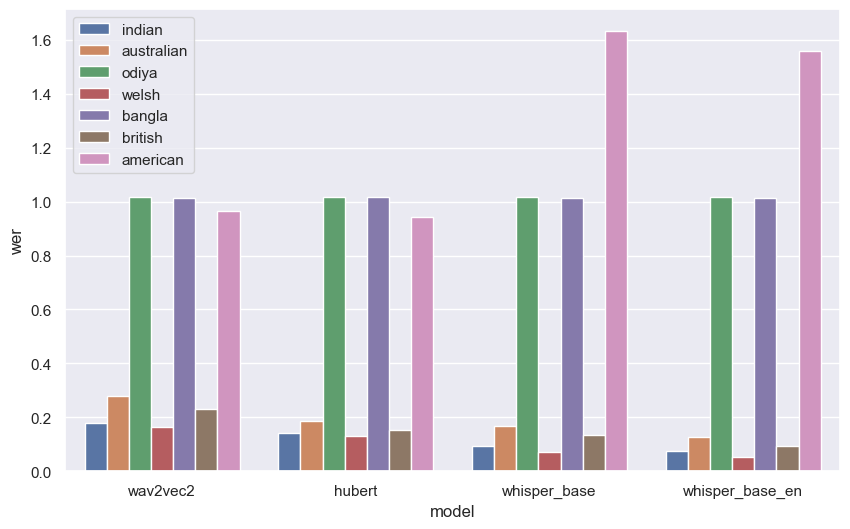

In [75]:
# plot a bar plot of the WER for each model per accent 
# make it bigger
plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
sns.barplot(data=wer_accent_df, x="model", y="wer", hue="accent")
plt.legend()
plt.savefig('../results/wer_accent_en.png')


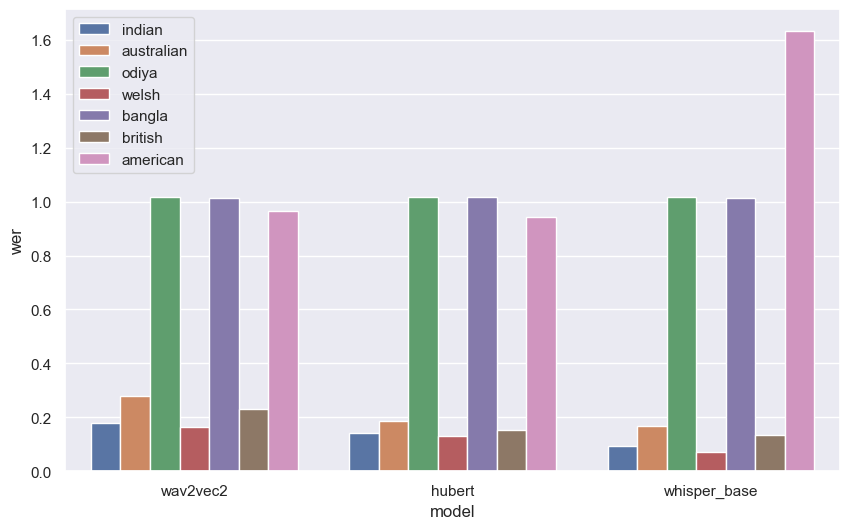

In [73]:
# exclude whisper_base_en
wer_accent_df = wer_accent_df[wer_accent_df['model'] != 'whisper_base_en']
# plot a bar plot of the WER for each model per accent
# make it bigger
plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
sns.barplot(data=wer_accent_df, x="model", y="wer", hue="accent")
plt.legend()
plt.savefig('../results/wer_accent.png')